## Замечания:
Актуально:
* С дисбалансом из-за полупустых классов можно бороться либо удалением маленьких классов, либо **пересемплированием**. Пока выбираю второй вариант, но в любом случае чудес ждать от предсказания маленьких по объему классов не стоит - если в обучающей выборке есть 1 строка какого-то класса, значит он будет предсказывать этот класс исключительно при полном соответствии тестовых строк данной одной строке. 
*


Актуально для меня:
* Можно улучшить обработку текстовых данных (можно попробовать в сыром виде запихать в кэтбуст)
* Если лемматизация будет работать долго (есть такая вероятность) - можно поменять на стеммер

Старое:
* Время работы? - **нужно протестировать на больших датасетах**
* Полупустые классы из-за которых возникает дисбаланс - **бороться**

* Вариант с тем, что в одной колонке название характеристики, в другой значение будет работать плохо (вот пример), т.к. модели без разницы на порядок следования колонок
* Правильно ли я понимаю, что все колонки кроме ХК 1 и целевой имеют тип данных String?
* **Как предсказывать строки с пустыми значениями во всех колонках ХК? (может их сразу откидывать)?**
* Названия первой колонки должны быть всегда одинаковые
* !!!Важно!!! Будем заменять числовые факторы на категориальные, если в них маленькое количество уникальных значений или одно значение встречается очень часто
* Были ошибки в названиях колонок: 'ХК_ка т_01'

**Проблемы, решение которых нужно будет автоматизировать:**
* Несбалансированность классов
* Пропуски в данных
* Автоматическое кодирование текстовых столбцов

In [186]:
#!pip install loguru
#!pip install imblearn
#!pip install pymystem3
#!pip install catboost
#!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
from loguru import logger
import re
from nltk.corpus import stopwords
#from pymystem3 import Mystem
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

#nltk.download('punkt')
#nltk.download('stopwords')

#### Глобальные переменные

In [3]:
# Максимальное количество уникальных значений для категориального фактора, при котором он может обрабатываться методом one-hot encoding (добавится максимум столько столбцов)
OneHotEncodingLimit = 30

### Работа с данными

In [126]:
#df = pd.read_excel('data/tubes_classificator_data.xlsx')
df = pd.read_csv('data/tubes_classificator_data.csv',encoding='cp1251', sep=';')
#df = pd.read_excel('data/paper_classificator_data.xlsx')

In [5]:
#df = df.drop('Историческое наименование', axis = 1)

In [127]:
#df = df[df['ID класса (ТАРГЕТ)'].notna()]
df = df[df['ID класса'].notna()]

In [128]:
df.head(1)

,ID класса,Наименование терминального класса,Код родительского класса,Наименование родительского класса,Историческое наименование,ХК_Кат_01,Значение ХК_Кат_01,ХК_Кат_02,Значение ХК_Кат_02,ХК_Кат_03,...,ХК_Стр_02,Значение ХК_Стр_02,ХК_Стр_03,Значение ХК_Стр_03,ХК_Стр_04,Значение ХК_Стр_04,ХК_Стр_05,Значение ХК_Стр_05,ХК_Стр_06,Значение ХК_Стр_06
0,100100,Труба стальная,NaN,NaN,"Труба 100х100х3 Ст3сп, 12м, 1шт/109кг, ГОСТ 30...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Длина,12м,Масса единицы,1шт/109кг,НТД,ГОСТ 30245,NaN,NaN


In [130]:
target = df['ID класса']

# Удалим все лишние текстовые столбцы кроме "Исторического наименования"
trainset_columns = []
for column in df.columns:
    if (column == 'Историческое наименование') or (re.fullmatch(r'ХК_.*', column)!=None) or (re.fullmatch(r'Значение.*', column)!=None):
        trainset_columns.append(column)

factors_df = df[trainset_columns]

#### Работаем с типами данных столбцов

In [131]:
def format_column_types(columns: list):
    '''
    Обрабатывает названия колонок из массива columns.
    Возвращает словарь с парами: название колонки - ее тип данных  
    '''
    feature_types_dict = {}
    for column in columns:
        type_pattern = r'ХК_([^_]+)_.*'
        if column[0:2] == 'ХК':
            feature_types_dict[column] = 'Кат'
        elif column[0:8]=='Значение':
            column_type = re.findall(type_pattern, column)[0]
            feature_types_dict[column] = column_type
        else:
            feature_types_dict[column] = 'Стр'
    return feature_types_dict

feature_types_dict = format_column_types(factors_df.columns)

In [132]:
def check_number_to_categorical(column: str, factor: pd.Series):
    logger.info(f'Начинаем проверку численного фактора {column}\n')
    logger.debug(f'Размер фактора:{factor.size}')
    logger.debug(f'Количество уникальных значений: {factor.drop_duplicates().size}')
    logger.debug(f'Процент заполненности фактора: {factor[factor.notnull()].size / factor.size * 100}%')
    popular_value = pd.DataFrame(factor.value_counts().sort_values(ascending=False).head(1)/factor[factor.notnull()].size*100)
    popular_value.columns = ['Частота']
    logger.debug(f'Cамое частое значение фактора: \n{popular_value}')
    
    if float(popular_value.iloc[0])>=50:
        logger.info(f'Переводим числовой фактор {column} в категориальный')
        return True
    
    
for feature in feature_types_dict.keys():
    if feature_types_dict.get(feature) == 'Стр':
        #logger.debug(f'Строковый фактор: {feature}')
        #todo ДОДЕЛАТЬ пока ничего не делаем, чтобы не потерять пропущенные значения при преобразовании в строковый формат
        factors_df_copy = factors_df.copy()
        factors_df[feature] = factors_df_copy[feature].astype(object)
    elif feature_types_dict.get(feature) == 'Булево':
        factors_df_copy = factors_df.copy()
        factors_df[feature] = factors_df_copy[feature].astype(bool)
    elif feature_types_dict.get(feature) == 'Числ':
        if check_number_to_categorical(feature, factors_df[feature]):
            feature_types_dict[feature] = 'Кат'
            factors_df_copy = factors_df.copy()
            factors_df[feature] = factors_df_copy[feature].astype(object)
        else:
            factors_df_copy = factors_df.copy()
            factors_df[feature] = factors_df_copy[feature].astype(float)
    elif feature_types_dict.get(feature) == 'Кат':
        logger.debug(f'Категориальный фактор: {feature}')
        #todo ДОДЕЛАТЬ преобразование категориальных колонок (пока не делаем, т.к. возможно будет catboost)


C:\Users\User\AppData\Local\Temp\ipykernel_11932\1022614043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors_df[feature] = factors_df_copy[feature].astype(object)
2023-10-23 18:35:11.329 | DEBUG    | __main__:<module>:33 - Категориальный фактор: ХК_Кат_01
2023-10-23 18:35:11.330 | DEBUG    | __main__:<module>:33 - Категориальный фактор: Значение ХК_Кат_01
2023-10-23 18:35:11.330 | DEBUG    | __main__:<module>:33 - Категориальный фактор: ХК_Кат_02
2023-10-23 18:35:11.331 | DEBUG    | __main__:<module>:33 - Категориальный фактор: Значение ХК_Кат_02
2023-10-23 18:35:11.331 | DEBUG    | __main__:<module>:33 - Категориальный фактор: ХК_Кат_03
2023-10-23 18:35:11.332 | DEBUG    | __main__:<module>:33 - Категориальный фактор: Значение ХК_Кат

#### Заполняем пропуски в данных
В зависимости от типа данных колонки заполняем пропуски по-разному:
*   Стр -  т.к. переводим строки в числа, то пропущенные значение пусть будут = 0
*   Числ - #todo По умолчанию = 0. Если присутствует значение, количество которого в заполненных строках >=50% => то фактор станет категориальным, а не численным. 
*   Булево - #todo будем считать, что у нас всегда такие столбцы отвечают на вопрос: "Есть что-то? - Да/Нет". Если нет ответа => Нет
*   Кат - 'Emptyclass'

In [134]:
factors_df.count()

Историческое наименование    1665
ХК_Кат_01                     478
Значение ХК_Кат_01            478
ХК_Кат_02                     724
Значение ХК_Кат_02            724
ХК_Кат_03                      97
Значение ХК_Кат_03             97
ХК_Кат_04                     315
Значение ХК_Кат_04            315
ХК_Кат_05                     436
Значение ХК_Кат_05            436
ХК_Кат_06                    1434
Значение ХК_Кат_06           1434
ХК_Кат_07                    1665
Значение ХК_Кат_07           1665
ХК_Стр_01                    1651
Значение ХК_Стр_01           1651
ХК_Стр_02                     521
Значение ХК_Стр_02            521
ХК_Стр_03                     673
Значение ХК_Стр_03            673
ХК_Стр_04                     294
Значение ХК_Стр_04            294
ХК_Стр_05                     719
Значение ХК_Стр_05            719
ХК_Стр_06                     214
Значение ХК_Стр_06            214
dtype: int64

In [133]:
factors_df.isna().sum()

Историческое наименование       0
ХК_Кат_01                    1187
Значение ХК_Кат_01           1187
ХК_Кат_02                     941
Значение ХК_Кат_02            941
ХК_Кат_03                    1568
Значение ХК_Кат_03           1568
ХК_Кат_04                    1350
Значение ХК_Кат_04           1350
ХК_Кат_05                    1229
Значение ХК_Кат_05           1229
ХК_Кат_06                     231
Значение ХК_Кат_06            231
ХК_Кат_07                       0
Значение ХК_Кат_07              0
ХК_Стр_01                      14
Значение ХК_Стр_01             14
ХК_Стр_02                    1144
Значение ХК_Стр_02           1144
ХК_Стр_03                     992
Значение ХК_Стр_03            992
ХК_Стр_04                    1371
Значение ХК_Стр_04           1371
ХК_Стр_05                     946
Значение ХК_Стр_05            946
ХК_Стр_06                    1451
Значение ХК_Стр_06           1451
dtype: int64

In [135]:
not_empty_factors_df = factors_df.copy()
for column in not_empty_factors_df.columns:
    if feature_types_dict.get(column) == 'Кат':
        not_empty_factors_df.loc[not_empty_factors_df[column].isna(), column] = f'EmptyCat'
    elif feature_types_dict.get(column) == 'Числ':
        not_empty_factors_df.loc[not_empty_factors_df[column].isna(), column] = 0
    elif feature_types_dict.get(column) == 'Стр':
        not_empty_factors_df.loc[not_empty_factors_df[column].isna(), column] = ''
    elif feature_types_dict.get(column) == 'Булево':
        not_empty_factors_df.loc[not_empty_factors_df[column].isna(), column] = 0


In [136]:
not_empty_factors_df.isna().sum()

Историческое наименование    0
ХК_Кат_01                    0
Значение ХК_Кат_01           0
ХК_Кат_02                    0
Значение ХК_Кат_02           0
ХК_Кат_03                    0
Значение ХК_Кат_03           0
ХК_Кат_04                    0
Значение ХК_Кат_04           0
ХК_Кат_05                    0
Значение ХК_Кат_05           0
ХК_Кат_06                    0
Значение ХК_Кат_06           0
ХК_Кат_07                    0
Значение ХК_Кат_07           0
ХК_Стр_01                    0
Значение ХК_Стр_01           0
ХК_Стр_02                    0
Значение ХК_Стр_02           0
ХК_Стр_03                    0
Значение ХК_Стр_03           0
ХК_Стр_04                    0
Значение ХК_Стр_04           0
ХК_Стр_05                    0
Значение ХК_Стр_05           0
ХК_Стр_06                    0
Значение ХК_Стр_06           0
dtype: int64

#### Кодируем переменные
* bag_of_words - пока остановимся на нем

In [137]:
russian_stopwords = stopwords.words("russian")
stemmer = SnowballStemmer("russian")

def text_preprocessing(text):
    #tokens = mystem.lemmatize(text)
    tokens = [stemmer.stem(token) for token in text.split() if token not in russian_stopwords and token != " "  and token.strip() not in punctuation]
    tokens = ' '.join(tokens)
    return tokens

def text_feature_preprocessing(text_feature):
    '''
    Функция преобразования текстовых факторов
    - Переводим в нижний регистр
    - Удаляем знаки препинания
    - Удаляем стоп слова
    - Проводим лемматизацию
    '''
    processed_feature = []
    text_feature = text_feature.replace(r'[^\w\s]',' ', regex=True).replace(r'\s+',' ', regex=True).str.lower()
    processed_text_feature = text_feature.apply(text_preprocessing)
    return processed_text_feature
    #return text_feature

vectorizer = TfidfVectorizer(
        min_df = 20,
        max_features=20,
        analyzer='word',
        stop_words = russian_stopwords
)

def handle_text_feature(text_feature: pd.Series):
    '''
    Функция обработки строкового фактора:
    - Проводим препроцессинг
    - Формируем "Мешок строк" (bag of words)
    '''
    #text_feature = text_feature.drop_duplicates()
    processed_text_feature = text_feature_preprocessing(text_feature)
    
    vectorizer.fit(processed_text_feature)
    vectorized_text_feature = pd.DataFrame(vectorizer.transform(processed_text_feature).toarray())

    # Удалим неинформативные столбцы
    informative_word_columns = vectorized_text_feature.sum()[
            (vectorized_text_feature.sum()>=vectorized_text_feature.shape[1]*0.01) &
            (vectorized_text_feature.sum()!=vectorized_text_feature.shape[1])
        ].index 
    handled_text_feature = vectorized_text_feature[informative_word_columns]
    handled_text_feature = handled_text_feature.fillna('EmptyStr')
    handled_text_feature.columns = pd.Series(vectorizer.get_feature_names_out())[informative_word_columns]
    return handled_text_feature

In [138]:
from sklearn.preprocessing import LabelEncoder

def handle_cat_feature(cat_feature: pd.Series):
    cat_feature = cat_feature.astype(str)
    unique_values_count = cat_feature.drop_duplicates().size
    if unique_values_count <= OneHotEncodingLimit:
        #OneHotEncoding
        cat_feature_encoded = pd.get_dummies(cat_feature)
    else:
        #LabelEncoding - чтобы сильно не увеличивать количество факторов
        le = LabelEncoder()
        cat_feature_encoded = pd.DataFrame(le.fit_transform(cat_feature))
    return cat_feature_encoded

In [139]:
trainset = pd.DataFrame()
copy_df = not_empty_factors_df.copy()

for feature in feature_types_dict:
    if feature_types_dict.get(feature) == 'Стр':
        handled_feature = handle_text_feature(not_empty_factors_df[feature])
        handled_feature = handled_feature.fillna('')
        #handled_feature = handle_text_feature(copy_df[feature])
    elif feature_types_dict.get(feature) == 'Кат':
        handled_feature = handle_cat_feature(not_empty_factors_df[feature])
        #handled_feature = handle_cat_feature(copy_df[feature])
    else:
        handled_feature = pd.DataFrame(not_empty_factors_df[feature])
        #handled_feature = pd.DataFrame(copy_df[feature])
    handled_feature.columns = [str(col)+'_'+str(feature) for col in handled_feature.columns]  
    trainset = pd.concat([trainset,handled_feature],axis=1)

g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [140]:
trainset.head()

,0м_Историческое наименование,10704_Историческое наименование,1шт_Историческое наименование,30245_Историческое наименование,304_Историческое наименование,6м_Историческое наименование,aisi_Историческое наименование,бесшовн_Историческое наименование,вес_Историческое наименование,гост_Историческое наименование,...,86_Значение ХК_Стр_05,8639_Значение ХК_Стр_05,8645_Значение ХК_Стр_05,8732_Значение ХК_Стр_05,91_Значение ХК_Стр_05,гост_Значение ХК_Стр_05,EmptyCat_ХК_Стр_06,Производитель_ХК_Стр_06,вмз_Значение ХК_Стр_06,северстал_Значение ХК_Стр_06
0,0.0,0.0,0.642845,0.631067,0.0,0.0,0.0,0.0,0.0,0.381094,...,0.0,0.000000,0.0,0.0,0.0,0.521247,True,False,0.0,0.0
1,0.0,0.0,0.642845,0.631067,0.0,0.0,0.0,0.0,0.0,0.381094,...,0.0,0.000000,0.0,0.0,0.0,0.521247,True,False,0.0,0.0
2,0.0,0.0,0.527774,0.518104,0.0,0.0,0.0,0.0,0.0,0.312878,...,0.0,0.000000,0.0,0.0,0.0,0.521247,True,False,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.464852,...,0.0,0.629137,0.0,0.0,0.0,0.317842,True,False,0.0,0.0
4,0.0,0.0,0.642845,0.631067,0.0,0.0,0.0,0.0,0.0,0.381094,...,0.0,0.000000,0.0,0.0,0.0,0.521247,True,False,0.0,0.0


In [28]:
from sklearn.feature_selection import chi2

features_chi2 = chi2(vectorizer.get_feature_names_out())
indices = np.argsort(features_chi2[0])
feature_names = np.array(vectorizer.get_feature_names_out())[indices]

TypeError: chi2() missing 1 required positional argument: 'y'

#### Сэмплируем классы, в которых всего 1 экземпляр и делим на обучающую и тестовую выборки

In [141]:
target.value_counts()

ID класса
100110    408
100120    338
100204    249
100201    221
100100    151
100200    111
100111     72
100101     44
100105     28
100103     18
100102     10
100301      6
100104      3
100203      2
100113      1
100202      1
100112      1
100121      1
Name: count, dtype: int64

In [142]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
trainset_res, target_res = ros.fit_resample(trainset, target)
target_res.value_counts()

g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

ID класса
100100    408
100110    408
100113    408
100204    408
100301    408
100120    408
100112    408
100111    408
100104    408
100202    408
100102    408
100103    408
100101    408
100201    408
100203    408
100105    408
100200    408
100121    408
Name: count, dtype: int64

#### Уменьшаем размерность

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5)
reproduced_trainset = pca.fit_transform(trainset_res)

g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


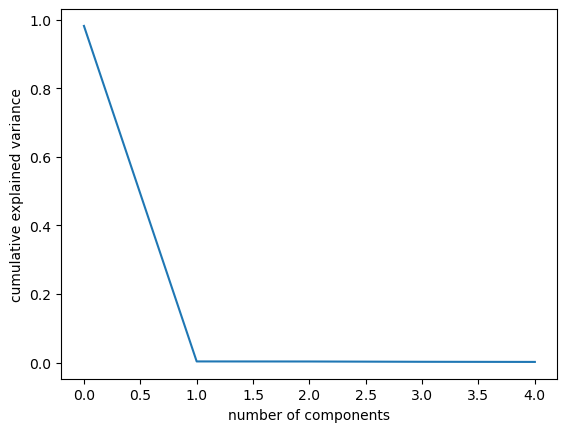

In [170]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [171]:
reproduced_trainset.shape

(7344, 5)

In [172]:
trainset_res.shape

(7344, 136)

In [173]:
target_res.shape

(7344,)

In [182]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(
    trainset_res,
    #reproduced_trainset, 
    target_res, 
    test_size=0.3, 
    random_state=42,
    #stratify=target    
) 

In [183]:
train_data.shape

(5140, 136)

#### RandomForestClassifier

In [184]:
from sklearn.ensemble import RandomForestClassifier

In [185]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(train_data, train_labels)

g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

RandomForestClassifier(random_state=0)

In [186]:
predicted_labels = rfc.predict(test_data)

g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [187]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(test_labels, predicted_labels)
report = classification_report(test_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.9986388384754991
Classification Report:
               precision    recall  f1-score   support

      100100       1.00      1.00      1.00       128
      100101       1.00      1.00      1.00       115
      100102       1.00      1.00      1.00       126
      100103       1.00      1.00      1.00       119
      100104       1.00      1.00      1.00       117
      100105       1.00      1.00      1.00       118
      100110       1.00      1.00      1.00       114
      100111       1.00      1.00      1.00       114
      100112       1.00      1.00      1.00       121
      100113       1.00      1.00      1.00       129
      100120       0.99      0.98      0.99       122
      100121       1.00      1.00      1.00       119
      100200       1.00      1.00      1.00       121
      100201       1.00      1.00      1.00       131
      100202       1.00      1.00      1.00       132
      100203       1.00      1.00      1.00       119
      100204       0.99     

g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
g:\Apps\anaconda3\envs\qlever\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

In [188]:
feature_importances = pd.DataFrame(rfc.feature_importances_, columns=['importance'])
feature_importances.index = train_data.columns
feature_importances.sort_values(by=['importance'], ascending=False)[:20]

,importance
профильн_Историческое наименование,0.043749
0_Значение ХК_Кат_06,0.041681
EmptyCat_Значение ХК_Кат_02,0.034463
Технология изготовления_ХК_Кат_02,0.032796
электросварн_Историческое наименование,0.031900
электросварная_Значение ХК_Кат_02,0.030975
EmptyCat_ХК_Кат_02,0.028465
EmptyCat_Значение ХК_Кат_01,0.028206
труб_Историческое наименование,0.027966
профильная_Значение ХК_Кат_01,0.025954


In [89]:
test_labels.value_counts().sort_values()

ID класса (ТАРГЕТ)
20000414    15
20000205    15
20000258    17
20000430    17
20000040    18
            ..
20000419    40
20000019    40
20000559    41
9240416     41
20000170    44
Name: count, Length: 645, dtype: int64

In [93]:
predictions_df = test_data.copy()
predictions_df['predicted_class'] = predicted_labels
predictions_df['correct_class'] = test_labels
predictions_df = predictions_df.sort_values(by = ['predicted_class','correct_class'])
#predictions_df.to_csv('tire_predictions_df.csv', sep = ';', encoding='cp1251')

In [124]:
predictions_df.head()

,100t_Историческое наименование,175_Историческое наименование,185_Историческое наименование,195_Историческое наименование,205_Историческое наименование,215_Историческое наименование,225_Историческое наименование,235_Историческое наименование,245_Историческое наименование,255_Историческое наименование,...,wintercraft_Значение ХК_Стр_01,wr_Значение ХК_Стр_01,xl_Значение ХК_Стр_01,zen_Значение ХК_Стр_01,zero_Значение ХК_Стр_01,EmptyCat_ХК_Булево_01,Шипы_ХК_Булево_01,Значение ХК_Булево_01_Значение ХК_Булево_01,predicted_class,correct_class
9195,0.0,0.0,0.0,0.0,0.0,0.0,0.408651,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,True,True,3284155,3284155
8361,0.0,0.0,0.0,0.0,0.0,0.0,0.353611,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,True,True,3284155,3284155
9206,0.0,0.0,0.0,0.0,0.0,0.0,0.359104,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,True,True,3284155,3284155
7677,0.0,0.0,0.0,0.0,0.0,0.0,0.350837,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,True,True,3284155,3284155
9169,0.0,0.0,0.0,0.0,0.0,0.0,0.398426,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,True,True,3284155,3284155


#### Обучим модель CatBoostClassifier на подготовленных данных

In [113]:
from catboost import CatBoostClassifier

In [145]:
model = CatBoostClassifier(loss_function='MultiClass', logging_level='Verbose')

#Нужно контролить переобоучение, правильно выставить learning_rate

grid_small = {'learning_rate': [0.01],# 0.03, 0.09],
        'depth': [ 3]
        #'l2_leaf_reg': [1, 3, 5, 7, 9]
        }


grid_full = {'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09],
        'depth': [3, 4, 6, 7, 8, 9, 10],
        #'early_stopping_rounds': True,
        'l2_leaf_reg': [1, 3, 5, 7, 9]
        }

grid_search_result = model.grid_search(
        grid_small,
        X=train_data,
        y=train_labels,
)

0:	learn: 5.8021328	test: 5.8028781	best: 5.8028781 (0)	total: 4.36s	remaining: 1h 12m 36s
1:	learn: 5.7600391	test: 5.7615252	best: 5.7615252 (1)	total: 8.73s	remaining: 1h 12m 36s
2:	learn: 5.7070225	test: 5.7088004	best: 5.7088004 (2)	total: 13.3s	remaining: 1h 13m 40s
3:	learn: 5.6601069	test: 5.6619228	best: 5.6619228 (3)	total: 17.8s	remaining: 1h 13m 55s
4:	learn: 5.6294886	test: 5.6320792	best: 5.6320792 (4)	total: 22.2s	remaining: 1h 13m 40s
5:	learn: 5.5898019	test: 5.5922128	best: 5.5922128 (5)	total: 26.7s	remaining: 1h 13m 44s
6:	learn: 5.5461853	test: 5.5487469	best: 5.5487469 (6)	total: 31.3s	remaining: 1h 13m 58s
7:	learn: 5.5087435	test: 5.5118871	best: 5.5118871 (7)	total: 35.8s	remaining: 1h 14m 4s
8:	learn: 5.4728678	test: 5.4764603	best: 5.4764603 (8)	total: 40.5s	remaining: 1h 14m 24s
9:	learn: 5.4400767	test: 5.4432583	best: 5.4432583 (9)	total: 45.3s	remaining: 1h 14m 42s
10:	learn: 5.3952072	test: 5.3984957	best: 5.3984957 (10)	total: 50s	remaining: 1h 14m 52s


KeyboardInterrupt: 

In [ ]:
model.fit(train_data, train_labels)
preds_labels = model.predict(test_data)

In [73]:
model_2 = CatBoostClassifier(loss_function='MultiClass', logging_level='Verbose', learning_rate = 0.3, depth = 4)

#Нужно контролить переобоучение, правильно выставить learning_rate, метрика и функция потерь
model_2.fit(train_data, train_labels)
preds_labels = model_2.predict(test_data)

0:	learn: 4.4773927	total: 27.6s	remaining: 7h 40m 22s
1:	learn: 4.1295189	total: 54.8s	remaining: 7h 35m 20s
2:	learn: 3.5977834	total: 1m 21s	remaining: 7h 33m 10s


KeyboardInterrupt: 

In [71]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(test_labels, preds_labels)
report = classification_report(test_labels, preds_labels)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

ValueError: Found input variables with inconsistent numbers of samples: [18770, 437]

#### Удалим бесполезные факторы которые состоят из 1 уникального значения

In [ ]:
#Делаем это после кодирования категориалььных переменных
#for column in factors_df.columns:
#    unique_values_count = factors_df[column].drop_duplicates().size
#    if unique_values_count == 1:
#        new_factors_df = factors_df.drop(column, axis = 1)

In [ ]:
#new_factors_df.info()

In [ ]:
#new_factors_df['Наименование терминального класса'].value_counts()

* Удалить колонки для неполного соответствия: если есть [1,2,3,4] - удалить одну, чтобы не было зависимости
* Удалить строки без характеристик
* Отбор на основе важности признаков